# hw3 - ensembles

## 1 Подготовка данных

Загрузите и предобработайте данные (по своему усмотрению) из hw1

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from scipy.stats import uniform, randint
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('train_features_with_answers.csv')

In [3]:
# Age
median_age = np.median(data['age'].dropna())
data.loc[(data['age'] < 15) | (data['age'] > 22), 'age'] = median_age
data.loc[data['age'].isnull(), 'age'] = median_age

# Sex
valid_sex_values = {'F', 'M'}
data.loc[~data['sex'].isin(valid_sex_values), 'sex'] = np.nan

# Address
most_common_address = data['address'].mode()[0]
data.loc[data['address'].isnull(), 'address'] = most_common_address

In [4]:
def encode_features(df, target_variable):
    """
    Encodes binary features using Label Encoding and other categorical features using Target Encoding with K-fold cross-validation.

    Args:
        df: The input DataFrame.
        target_variable: The name of the target variable column.

    Returns:
        A DataFrame with encoded features. Returns None if errors occur.
    """

    # Identify binary and other categorical columns
    binary_cols = [col for col in df.columns if df[col].isin(['yes', 'no']).all()]
    other_categorical_cols = [col for col in df.select_dtypes(include=['object']).columns
                              if col not in binary_cols and col != target_variable]

    df_encoded = df.copy()
    
    # Label encode binary features
    le = LabelEncoder()
    for col in binary_cols:
        df_encoded[col] = le.fit_transform(df_encoded[col])
    
    encoder = ce.TargetEncoder(cols=other_categorical_cols, handle_missing="return_nan")

    df_encoded[other_categorical_cols] = encoder.fit_transform(df[other_categorical_cols], df[target_variable])

    return df_encoded

In [5]:
data_encoded = encode_features(data, target_variable='G3')

In [6]:
# scale data
g3 = data_encoded['G3']
data_no_g3 = data_encoded.drop('G3', axis=1)

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_no_g3)
data_scaled_df = pd.DataFrame(data_scaled, columns=data_no_g3.columns)

data_scaled = data_scaled_df.assign(G3=g3.values)

In [7]:
# predict incorrect sex
data_sex = data_scaled[data_scaled['sex'].notna()]
X_sex = data_sex.drop(['sex'], axis=1)
y_sex = data_sex['sex']

X_train_sex, X_test_sex, y_train_sex, y_test_sex = train_test_split(X_sex, y_sex, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train_sex, y_train_sex)

# Make predictions
y_pred = model.predict(X_test_sex)

X_sex = data_scaled[data_scaled['sex'].isnull()].drop(['sex'], axis=1)
y_sex = model.predict(X_sex)

data_scaled.loc[data['sex'].isnull(), 'sex'] = y_sex

In [8]:
# validation strategy
ss = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

In [9]:
# check
missing_values = data_scaled.isnull()
columns_none_info = pd.DataFrame(missing_values.T.sum(axis=1))
columns_none_info = columns_none_info.rename(columns={0: 'None count'}) 

columns_none_info[columns_none_info['None count'] != 0]

,None count


In [10]:
X = data_scaled.drop('G3', axis=1)
y = data_scaled['G3']

## 2 Обоснуйте выбор слабых (базовых) алгоритмов

+ GaussianNB: Быстрый и простой, особенно хорош для данных с “колоколообразным” распределением.
+ KNeighborsClassifier: Легко понять и использовать; не требует долгого обучения.
+ LogisticRegression: Простой, быстрый и дает вероятности принадлежности к классам.
+ SVC: Хорошо справляется со сложными данными и меньше переобучается, чем другие.
+ DecisionTreeClassifier: Легко понять, но может переобучиться.

## 3 Постройте решение на основе подхода Blending

Правила:
- Нужно использовать вероятности
- Предложите что-то лучше, чем брать среднее от предсказаний моделей (оценивать уверенность алгоритмов, точности и т.д.)
- Заставьте базовые алгоритмы быть некорелированными
- Добавьте рандома (например, стройте ваши алгоритмы на разных выборках, по разному предобрабатывайте данные или применяйте для разных признаков соответствующие алгоритмы ... )
- Проявите смекалку
- Цель: метрика MSE на тесте меньше 10

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
class Stacking:
    """
    A stacking ensemble model that combines predictions from multiple base estimators.
    Supports both blending (hold-out validation) and stacking (cross-validation).
    """
    def __init__(self, estimators, final_estimator, blending=False, cv=5, n_jobs=-1):
        """
        Initializes the Stacking object.

        Args:
            estimators: A list of base estimators.
            final_estimator: The final estimator that combines the base estimators' predictions.
            blending: A boolean indicating whether to use blending (True) or stacking (False). Defaults to False.
            cv: The number of cross-validation folds to use if blending is False. Defaults to 5.
            n_jobs: The number of jobs to run in parallel. -1 uses all processors. Defaults to -1.
        """
        self.estimators = estimators
        self.final_estimator = final_estimator
        self.blending = blending
        self.cv = cv
        self.n_jobs = n_jobs

    def _X_pred(self, estimator, data):
        """
        Generates predictions for training data using a single base estimator.

        Args:
            estimator: The base estimator to use.
            data: A tuple containing the training data (X_train, y_train) or (X_train, y_train, X_val) if blending is True.

        Returns:
            A NumPy array of predictions.
        """
        if self.blending:
            X_train_v, y_train_v, X_val = data
            return estimator.fit(X_train_v, y_train_v).predict(X_val)
        else:
            X_train, y_train = data
            return cross_val_predict(estimator, X_train, y_train, cv=self.cv)

    def _X_test_pred(self, estimator, data):
        """
        Generates predictions for test data using a single base estimator.

        Args:
            estimator: The base estimator to use.
            data: A tuple containing the training data (X_train, y_train) and the test data (X_test).

        Returns:
            A NumPy array of predictions.
        """
        X_train, y_train, X_test = data
        return estimator.fit(X_train, y_train).predict(X_test)

    def _meta_data(self, X_train, y_train, X_test):
        """
        Generates the meta-features for the final estimator.

        Args:
            X_train: The training features.
            y_train: The training target variable.
            X_test: The test features.

        Returns:
            A tuple containing the meta-features for training (meta_X_train), 
            the training target variable (meta_y_train), and the meta-features for testing (meta_X_test).
        """
        if self.blending:
            # Use hold-out cross-validation for blending
            X_train_v, X_val, y_train_v, y_val = train_test_split(X_train, y_train, random_state=0)
            train_data = [X_train_v, y_train_v, X_val]
            test_data = [X_train_v, y_train_v, X_test]
            meta_y_train = y_val
        else:
            train_data = [X_train, y_train]
            test_data = [X_train, y_train, X_test]
            meta_y_train = y_train

        cv_X_train_preds = (delayed(self._X_pred)(est, train_data) for est in self.estimators)
        X_test_preds = (delayed(self._X_test_pred)(est, test_data) for est in self.estimators)

        meta_X_train = pd.DataFrame(Parallel(n_jobs=self.n_jobs)(cv_X_train_preds))
        meta_X_test = pd.DataFrame(Parallel(n_jobs=self.n_jobs)(X_test_preds))

        return meta_X_train.T, meta_y_train, meta_X_test.T

    def fit_predict(self, X_train, y_train, X_test):
        """
        Fits the stacking ensemble and generates predictions on the test set.

        Args:
            X_train: The training features.
            y_train: The training target variable.
            X_test: The test features.

        Returns:
            A NumPy array of predictions on the test set.
        """
        meta_X_train, meta_y_train, meta_X_test = self._meta_data(X_train, y_train, X_test)
        return self.final_estimator.fit(meta_X_train, meta_y_train).predict(meta_X_test)

In [13]:
# Add random to parameters of models
reg_estimators = [
    ('gnb', GaussianNB()),
    ('knn', KNeighborsRegressor()),
    ('lr', LinearRegression()),
    ('svr', SVR()),
    ('rf', RandomForestRegressor(random_state=0))
]

param_distributions = {
    'gnb': {},
    'knn': {'n_neighbors': randint(1, 50)},
    'lr': {'fit_intercept': [True, False]},
    'svr': {'C': uniform(1, 100), 'gamma': uniform(0.01, 10), 'kernel':['rbf', 'linear']},
    'rf': {'n_estimators': randint(10, 200), 'max_depth': randint(1, 30), 'min_samples_split': randint(2,20)}
}

def random_search_estimator(estimator, X, y, param_distribution, cv=5):
    random_search = RandomizedSearchCV(estimator, param_distributions=param_distribution, n_iter=10, scoring='neg_mean_squared_error', cv=cv, random_state=42, n_jobs=-1) # Number of iterations to run the randomized search. Adjust as needed.
    random_search.fit(X,y)
    best_estimator = random_search.best_estimator_
    return best_estimator

best_estimators = []
for name, estimator in reg_estimators:
    best_estimator = random_search_estimator(estimator, X_train, y_train, param_distributions[name], cv=ss)
    best_estimators.append(best_estimator)

best_estimators

/home/nur/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/nur/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[GaussianNB(),
 KNeighborsRegressor(n_neighbors=8),
 LinearRegression(),
 SVR(C=3.0584494295802447, gamma=9.709098521619943, kernel='linear'),
 RandomForestRegressor(max_depth=7, min_samples_split=16, n_estimators=116,
                       random_state=0)]

/home/nur/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/home/nur/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/home/nur/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/nur/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/home/nur/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


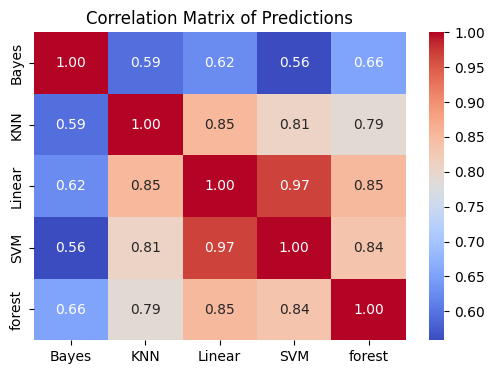

In [14]:
data = {'Bayes': best_estimators[0].predict(X_test.values),
        'KNN': best_estimators[1].predict(X_test.values), 
        'Linear': best_estimators[2].predict(X_test.values), 
        'SVM': best_estimators[3].predict(X_test.values), 
        'forest': best_estimators[4].predict(X_test.values)}
df = pd.DataFrame(data)

correlation_matrix = df.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Predictions')
plt.show()

In [15]:
# Stacking
stacking_reg = Stacking(estimators=best_estimators, final_estimator=RidgeCV())
stacking_reg_pred_res = stacking_reg.fit_predict(X_train, y_train, X_test)

mse = mean_squared_error(y_test, stacking_reg_pred_res)
print(f'MSE: {np.round(mse, 2)}')

/home/nur/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


MSE: 7.65


## 4 Постройте решение на основе подхода Stacking

Правила:
- Реализуйте пайплайн обучения и предсказания (например, sklearn.pipeline или класс)
- Проведите оптимизацию пайплайна
- Оцените вклад каждого базового алгоритма в итоговое предсказание
- Цель: метрика MSE на тесте меньше 10

In [16]:
stacking_reg = Stacking(estimators=best_estimators, final_estimator=RidgeCV(), blending=True)
stacking_reg_pred_res = stacking_reg.fit_predict(X_train, y_train, X_test)

mse = mean_squared_error(y_test, stacking_reg_pred_res)
print(f'MSE: {np.round(mse, 2)}')

MSE: 8.13


## * Доп задание (не обязательно, но решение будет поощряться)

Правила:
- Постройте несколько сильных алгоритмов разного класса (это может быть бустинг, нейросеть, ансамбль слабых алгоритмов, алгоритм на статистике, что придумаете)
- Реализуйте "управляющий" алгоритм, который на основе входных данных будет выбирать, какой из  сильных алгоритмов запустить (не на основе их работы, а именно на основе данных)